In [1]:
import os

os.environ["GRB_LICENSE_FILE"] = r"C:\Users\PC1\gurobi.lic"

import gurobipy as gp
from gurobipy import GRB 


In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional, Dict, Any


# =========================================================
# Data structures
# =========================================================

@dataclass(frozen=True)
class StandardFormMILP:
    """
    Standard-form-ish MILP container.
    We support mixed senses (>=, <=, =) and mixed variable types.
    Objective: min c^T x
    Constraints: A x (sense) b
    """
    A: np.ndarray                 # shape (m,n)
    b: np.ndarray                 # shape (m,)
    sense: List[str]              # length m, each in {">=", "<=", "="}
    c: np.ndarray                 # shape (n,)
    lb: np.ndarray                # shape (n,)
    ub: np.ndarray                # shape (n,)
    vtype: List[str]              # length n, each in {"C","I","B"}


@dataclass(frozen=True)
class MutableSpec:
    """
    Which parameters are mutable, and their integer delta bounds.

    - b_idx: indices of RHS entries b_i that can change
    - c_idx: indices of objective coefficients c_j that can change
    - A_idx: list of (i,j) indices of A_ij coefficients that can change

    Delta bounds are uniform here for simplicity; you can extend to per-index bounds.
    """
    b_idx: List[int]
    c_idx: List[int]
    A_idx: List[Tuple[int,int]]
    delta_lb: int   # integer lower bound for each delta component
    delta_ub: int   # integer upper bound for each delta component


# =========================================================
# Model builder (standard form -> Gurobi)
# =========================================================

def build_forward_model(data: StandardFormMILP,
                        override: Optional[Dict[str, Any]] = None,
                        output_flag: int = 0,
                        time_limit: Optional[float] = None,
                        threads: int = 1):
    """
    Build a fresh Gurobi model from standard-form data.
    override can contain updated A, b, c (numpy arrays).
    Returns (model, x_vars, constrs, obj_expr).
    """
    A = data.A if override is None or "A" not in override else override["A"]
    b = data.b if override is None or "b" not in override else override["b"]
    c = data.c if override is None or "c" not in override else override["c"]

    m, n = A.shape
    model = gp.Model("forward")
    model.Params.OutputFlag = output_flag
    model.Params.Threads = int(threads)
    if time_limit is not None:
        model.Params.TimeLimit = float(time_limit)

    # Variables
    x = []
    for j in range(n):
        vt = data.vtype[j]
        if vt not in ("C", "I", "B"):
            raise ValueError(f"Invalid vtype[{j}]={vt}. Use 'C','I','B'.")
        xj = model.addVar(lb=float(data.lb[j]), ub=float(data.ub[j]),
                          vtype={"C":GRB.CONTINUOUS,"I":GRB.INTEGER,"B":GRB.BINARY}[vt],
                          name=f"x[{j}]")
        x.append(xj)

    # Objective
    obj = gp.quicksum(float(c[j]) * x[j] for j in range(n))
    model.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    constrs = []
    for i in range(m):
        lhs = gp.quicksum(float(A[i,j]) * x[j] for j in range(n))
        s = data.sense[i]
        if s == ">=":
            ci = model.addConstr(lhs >= float(b[i]), name=f"con[{i}]")
        elif s == "<=":
            ci = model.addConstr(lhs <= float(b[i]), name=f"con[{i}]")
        elif s == "=":
            ci = model.addConstr(lhs == float(b[i]), name=f"con[{i}]")
        else:
            raise ValueError(f"Invalid sense[{i}]={s}. Use '>=','<=','='.")
        constrs.append(ci)

    model.optimize()
    return model, x, constrs, obj


# =========================================================
# Apply deltas to (A,b,c)
# =========================================================

def apply_deltas(base: StandardFormMILP,
                 spec: MutableSpec,
                 delta_b: np.ndarray,
                 delta_c: np.ndarray,
                 delta_A: np.ndarray):
    """
    Produces new (A,b,c) = (A0+ΔA, b0+Δb, c0+Δc) based on spec ordering.
    """
    A = base.A.copy()
    b = base.b.copy()
    c = base.c.copy()

    for k, i in enumerate(spec.b_idx):
        b[i] = b[i] + delta_b[k]
    for k, j in enumerate(spec.c_idx):
        c[j] = c[j] + delta_c[k]
    for k, (i,j) in enumerate(spec.A_idx):
        A[i,j] = A[i,j] + delta_A[k]

    return A, b, c


# =========================================================
# Witness check for WCE (existential / optimistic)
# =========================================================

def witness_exists(base: StandardFormMILP,
                   A: np.ndarray, b: np.ndarray, c: np.ndarray,
                   theta: float,
                   desired_space_cb: Callable[[gp.Model, List[gp.Var], List[gp.Constr]], None],
                   tol: float = 1e-6,
                   output_flag: int = 0,
                   time_limit: Optional[float] = None,
                   threads: int = 1):
    model, x, constrs, obj = build_forward_model(
        StandardFormMILP(A=A, b=b, sense=base.sense, c=c, lb=base.lb, ub=base.ub, vtype=base.vtype),
        override=None,
        output_flag=output_flag,
        time_limit=time_limit,
        threads=threads
    )

    desired_space_cb(model, x, constrs)
    model.addConstr(obj <= theta + tol, name="optimality_cap")

    model.optimize()

    if model.Status == GRB.OPTIMAL:
        sol = {"obj": model.ObjVal, "x": np.array([v.X for v in x])}
        return "OPTIMAL", sol
    if model.Status == GRB.TIME_LIMIT:
        return "TIME_LIMIT", None
    return "NO_WITNESS", None


# =========================================================
# Master over delta variables with no-good cuts (enumerative CCG baseline)
# =========================================================

def build_master(spec: MutableSpec,
                 output_flag: int = 0,
                 time_limit: Optional[float] = None,
                 threads: int = 1):
    model = gp.Model("master")
    model.Params.OutputFlag = output_flag
    model.Params.Threads = int(threads)
    if time_limit is not None:
        model.Params.TimeLimit = float(time_limit)

    # Delta variables
    db = [model.addVar(vtype=GRB.INTEGER, lb=spec.delta_lb, ub=spec.delta_ub, name=f"db[{k}]")
          for k in range(len(spec.b_idx))]
    dc = [model.addVar(vtype=GRB.INTEGER, lb=spec.delta_lb, ub=spec.delta_ub, name=f"dc[{k}]")
          for k in range(len(spec.c_idx))]
    dA = [model.addVar(vtype=GRB.INTEGER, lb=spec.delta_lb, ub=spec.delta_ub, name=f"dA[{k}]")
          for k in range(len(spec.A_idx))]

    def add_abs(v: gp.Var, name: str):
        p = model.addVar(lb=0.0, name=f"{name}_p")
        m = model.addVar(lb=0.0, name=f"{name}_m")
        model.addConstr(v == p - m, name=f"{name}_abs")
        return p + m

    abs_terms = []
    for k, v in enumerate(db):
        abs_terms.append(add_abs(v, f"abs_db[{k}]"))
    for k, v in enumerate(dc):
        abs_terms.append(add_abs(v, f"abs_dc[{k}]"))
    for k, v in enumerate(dA):
        abs_terms.append(add_abs(v, f"abs_dA[{k}]"))

    model.setObjective(gp.quicksum(abs_terms), GRB.MINIMIZE)
    model.update()
    return model, db, dc, dA



def add_no_good_cut(model: gp.Model,
                    vars_list: List[gp.Var],
                    values: List[int],
                    name: str):
    """
    Correct no-good cut for bounded integer variables:
    exclude exactly (vars_list == valuesvalues.

    Enforces: exists k such that v_k <= val_k-1 OR v_k >= val_k+1.
    Implemented via two indicator binaries per component.
    """
    assert len(vars_list) == len(values)

    if len(vars_list) == 0:
        model.addConstr(0 >= 1, name=name)
        return

    diffs = []
    for k, (v, val) in enumerate(zip(vars_list, values)):
        u = model.addVar(vtype=GRB.BINARY, name=f"{name}_u[{k}]")  # v >= val+1
        l = model.addVar(vtype=GRB.BINARY, name=f"{name}_l[{k}]")  # v <= val-1
        model.addConstr(u + l <= 1, name=f"{name}_one_side[{k}]")

        # If u=1 => v >= val+1
        model.addGenConstrIndicator(u, True, v >= val + 1, name=f"{name}_ge[{k}]")
        # If l=1 => v <= val-1
        model.addGenConstrIndicator(l, True, v <= val - 1, name=f"{name}_le[{k}]")

        diffs.append(u + l)

    model.addConstr(gp.quicksum(diffs) >= 1, name=f"{name}_exclude_point")
    model.update()



# =========================================================
# General WCE solver (enumerative CCG baseline)
# =========================================================

def solve_wce_general(base: StandardFormMILP,
                      spec: MutableSpec,
                      desired_space_cb: Callable[[gp.Model, List[gp.Var], List[gp.Constr]], None],
                      max_iter: int = 50,
                      tol: float = 0.0,
                      master_output: int = 0,
                      oracle_output: int = 0,
                      time_limit: float = 120.0,
                      threads: int = 1):
    master, db_vars, dc_vars, dA_vars = build_master(
        spec, output_flag=master_output, time_limit=time_limit, threads=threads
    )

    UB = float("inf")
    best = None

    for it in range(max_iter):
        master.optimize()

        if master.Status == GRB.TIME_LIMIT:
            return {"status": "TIME_LIMIT", "best": best}

        if master.Status != GRB.OPTIMAL:
            # infeasible master (no more delta points) or other status
            break

        db_val = np.array([int(round(v.X)) for v in db_vars], dtype=int)
        dc_val = np.array([int(round(v.X)) for v in dc_vars], dtype=int)
        dA_val = np.array([int(round(v.X)) for v in dA_vars], dtype=int)
        dist = float(master.ObjVal)

        A_new, b_new, c_new = apply_deltas(base, spec, db_val, dc_val, dA_val)

        # Oracle forward (theta)
        fwd_model, x_vars, constrs, obj_expr = build_forward_model(
            StandardFormMILP(A=A_new, b=b_new, sense=base.sense, c=c_new,
                             lb=base.lb, ub=base.ub, vtype=base.vtype),
            override=None,
            output_flag=oracle_output,
            time_limit=time_limit,
            threads=threads
        )

        if fwd_model.Status == GRB.TIME_LIMIT:
            return {"status": "TIME_LIMIT", "best": best}

        if fwd_model.Status != GRB.OPTIMAL:
            # exclude this delta vector
            all_master_vars = db_vars + dc_vars + dA_vars
            all_vals = list(db_val) + list(dc_val) + list(dA_val)
            add_no_good_cut(master, all_master_vars, all_vals, name=f"nogood_infeas[{it}]")
            continue

        theta = float(fwd_model.ObjVal)

        # Witness check
        w_status, witness = witness_exists(
            base, A_new, b_new, c_new, theta, desired_space_cb,
            tol=1e-6,
            output_flag=oracle_output,
            time_limit=time_limit,
            threads=threads
        )

        if w_status == "TIME_LIMIT":
            return {"status": "TIME_LIMIT", "best": best}

        if w_status == "OPTIMAL":
            if dist < UB:
                UB = dist
                best = {
                    "dist": UB,
                    "db": db_val, "dc": dc_val, "dA": dA_val,
                    "A": A_new, "b": b_new, "c": c_new,
                    "theta": theta,
                    "witness": witness,
                }
            if UB - dist <= tol:
                return {"status": "OPTIMAL", "best": best}

        # witness failed: exclude this delta vector
        all_master_vars = db_vars + dc_vars + dA_vars
        all_vals = list(db_val) + list(dc_val) + list(dA_val)
        add_no_good_cut(master, all_master_vars, all_vals, name=f"nogood[{it}]")

    return {"status": ("OPTIMAL" if best is not None else "NONE"), "best": best}



# =========================================================
# Demo on your toy (now in standard form)
# =========================================================

def demo():
    # Toy variables: x1,x2 continuous, y1,y2 binary
    # Put them into x vector as [x1,x2,y1,y2]
    # Objective: 2x1 + 1x2 + 3y1 + 1y2
    c0 = np.array([2, 1, 3, 1], dtype=float)

    # Constraints:
    # (1) x1 + x2 >= b
    # (2) x1 - 5 y1 <= 0
    # (3) x2 - 5 y2 <= 0
    # Standard form with mixed senses:
    A0 = np.array([
        [1, 1, 0, 0],
        [1, 0, -5, 0],
        [0, 1, 0, -5],
    ], dtype=float)
    sense = [">=", "<=", "<="]

    b0 = np.array([4, 0, 0], dtype=float)

    lb = np.array([0, 0, 0, 0], dtype=float)
    ub = np.array([GRB.INFINITY, GRB.INFINITY, 1, 1], dtype=float)
    vtype = ["C", "C", "B", "B"]

    base = StandardFormMILP(A=A0, b=b0, sense=sense, c=c0, lb=lb, ub=ub, vtype=vtype)

    # Desired space: y1 == 1  (x[2] is y1)
    def desired_cb(model: gp.Model, xvars: List[gp.Var], constrs: List[gp.Constr]):
        model.addConstr(xvars[2] == 1, name="desired_y1_on")
        model.addConstr(xvars[0] == 2.5, name="desired_x2_limit")

    # Mutable spec: allow changing ONLY the RHS of constraint (1) (b[0]) by integer deltas
    spec = MutableSpec(
        b_idx=[0,1],     # only demand RHS mutable
        c_idx=[],      # no cost changes
        A_idx=[(1,2),(2,3)],      # no A changes
        delta_lb=-10,
        delta_ub=+10
    )

    out = solve_wce_general(
        base=base,
        spec=spec,
        desired_space_cb=desired_cb,
        max_iter=50,
        master_output=0,
        oracle_output=0,
        time_limit=120.0,
        threads=1
    )

    print("STATUS:", out["status"])

    best = out["best"]
    if best is None:
        print("No WCE found.")
        return

    print("\n=== BEST WCE FOUND ===")
    print("L1 dist:", best["dist"])
    print("delta b:", best["db"])
    print("new b:", best["b"])
    print("theta:", best["theta"])
    print("witness obj:", best["witness"]["obj"])
    print("witness x:", best["witness"]["x"])



if __name__ == "__main__":
    demo()


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2671099
Academic license 2671099 - for non-commercial use only - registered to di___@ug.uchile.cl
STATUS: NONE
No WCE found.


In [3]:
def solve_forward_only(base: StandardFormMILP, A: np.ndarray, b: np.ndarray, c: np.ndarray,
                       output_flag: int = 0,
                       time_limit: Optional[float] = None,
                       threads: int = 1):
    fwd_model, x_vars, constrs, obj_expr = build_forward_model(
        StandardFormMILP(A=A, b=b, sense=base.sense, c=c, lb=base.lb, ub=base.ub, vtype=base.vtype),
        override=None,
        output_flag=output_flag,
        time_limit=time_limit,
        threads=threads
    )
    if fwd_model.Status == GRB.OPTIMAL:
        x = np.array([v.X for v in x_vars])
        return "OPTIMAL", fwd_model.ObjVal, x
    if fwd_model.Status == GRB.TIME_LIMIT:
        return "TIME_LIMIT", None, None
    return "NO_OPT", None, None



def compute_l1_dist_from_deltas(db: np.ndarray, dc: np.ndarray, dA: np.ndarray):
    return float(np.sum(np.abs(db)) + np.sum(np.abs(dc)) + np.sum(np.abs(dA)))


def sanity_check_wce_result(base: StandardFormMILP,
                            spec: MutableSpec,
                            desired_space_cb: Callable[[gp.Model, List[gp.Var], List[gp.Constr]], None],
                            best: Dict[str, Any],
                            tol: float = 1e-6,
                            output_flag: int = 0):
    """
    Sanity-check that 'best' is a valid WCE for the forward model:
      1) best['dist'] matches |deltas|_1
      2) theta is the forward optimum under (A,b,c)
      3) witness exists in desired space with obj <= theta + tol
      4) witness objective approximately equals theta (optional check)
    """
    assert best is not None, "best is None (no WCE found)."

    # 1) Check distance
    dist_calc = compute_l1_dist_from_deltas(best["db"], best["dc"], best["dA"])
    print("=== SANITY 1: Distance ===")
    print(f"reported dist = {best['dist']}, computed dist = {dist_calc}")
    if abs(best["dist"] - dist_calc) > 1e-6:
        print("WARNING: dist mismatch. (If master used weighted distance, this is expected.)")

    # 2) Re-solve forward
    print("\n=== SANITY 2: Forward optimality ===")
    theta_star, x_star = solve_forward_only(base, best["A"], best["b"], best["c"], output_flag=output_flag)
    if theta_star is None:
        raise RuntimeError("Forward model at best parameters is not optimal/feasible.")
    print(f"theta(recomputed) = {theta_star:.6f} | theta(stored) = {best['theta']:.6f} | gap = {best['theta'] - theta_star:.3e}")

    # 3) Witness existence
    print("\n=== SANITY 3: Witness exists in desired space at optimum ===")
    ok, wit = witness_exists(
        base=base,
        A=best["A"],
        b=best["b"],
        c=best["c"],
        theta=theta_star,
        desired_space_cb=desired_space_cb,
        tol=tol,
        output_flag=output_flag
    )
    print("witness_exists ?", ok)
    if not ok:
        raise RuntimeError("Sanity failed: no witness exists, so this is NOT a WCE.")

    print(f"witness obj = {wit['obj']:.6f} | theta = {theta_star:.6f} | wit-theta = {wit['obj'] - theta_star:.3e}")

    # 4) Optional: check witness objective approximately equals theta (it should, given your formulation)
    if wit["obj"] > theta_star + 1e-5:
        print("WARNING: witness objective is above theta; check your witness constraint/tolerance.")

    print("\n=== SANITY PASSED: This is a valid Weak Optimality CE ===")
    return {"theta": theta_star, "x_opt": x_star, "witness": wit}


In [4]:
def demo():
    # -------------------------------
    # 1) Define the base MILP
    # -------------------------------
    c0 = np.array([2, 1, 3, 1], dtype=float)

    A0 = np.array([
        [1, 1, 0, 0],
        [1, 0, -5, 0],
        [0, 1, 0, -5],
    ], dtype=float)

    sense = [">=", "<=", "<="]
    b0 = np.array([4, 0, 0], dtype=float)

    lb = np.array([0, 0, 0, 0], dtype=float)
    ub = np.array([GRB.INFINITY, GRB.INFINITY, 1, 1], dtype=float)
    vtype = ["C", "C", "B", "B"]

    base = StandardFormMILP(
        A=A0, b=b0, sense=sense,
        c=c0, lb=lb, ub=ub, vtype=vtype
    )

    # -------------------------------
    # 2) Desired space
    # -------------------------------
    def desired_cb(model, xvars, constrs):
        # y1 == 1  (x[2])
        model.addConstr(xvars[2] == 1, name="desired_y1_on")

    # -------------------------------
    # 3) Mutable specification
    # -------------------------------
    spec = MutableSpec(
        b_idx=[0],     # only demand RHS
        c_idx=[],
        A_idx=[],
        delta_lb=-10,
        delta_ub=10
    )

    # -------------------------------
    # 4) Solve WCE
    # -------------------------------
    out = solve_wce_general(
        base=base,
        spec=spec,
        desired_space_cb=desired_cb,
        max_iter=50,
        master_output=0,
        oracle_output=0,
        time_limit=120.0,
        threads=1
    )

    print("STATUS:", out["status"])

    best = out["best"]
    if best is None:
        print("No WCE found.")
        return

    print("\n=== BEST WCE FOUND ===")
    print("L1 dist:", best["dist"])
    print("delta b:", best["db"])
    print("new b:", best["b"])
    print("theta:", best["theta"])
    print("witness obj:", best["witness"]["obj"])
    print("witness x:", best["witness"]["x"])

    # -------------------------------
    # 5) Sanity check
    # -------------------------------
    print("\n=== RUN SANITY CHECK ===")
    sanity_check_wce_result(
        base=base,
        spec=spec,
        desired_space_cb=desired_cb,
        best=best,
        tol=1e-6,
        output_flag=0
    )


# ✅ ONLY THIS at top level
demo()


STATUS: OPTIMAL

=== BEST WCE FOUND ===
L1 dist: 2.0
delta b: [2]
new b: [6. 0. 0.]
theta: 11.0
witness obj: 11.0
witness x: [1. 5. 1. 1.]

=== RUN SANITY CHECK ===
=== SANITY 1: Distance ===
reported dist = 2.0, computed dist = 2.0

=== SANITY 2: Forward optimality ===


ValueError: too many values to unpack (expected 2)

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# GRID RUNNER for RHS-only Mixed WCE
# Produces: time_matrix (median wall-clock), feas_matrix (%), timeout_matrix (%)
# =========================================================

def choose_targets_from_forward(x_star: np.ndarray, vtype: list[str], D: int, seed: int) -> list[int]:
    rng = np.random.RandomState(seed)
    n = len(x_star)

    # Prefer binary variables that are active (==1)
    active_bin = [j for j in range(n) if vtype[j] == "B" and x_star[j] > 0.5]
    # Fallback: any positive variables
    active_any = [j for j in range(n) if x_star[j] > 1e-6]

    pool = active_bin if len(active_bin) > 0 else active_any
    if len(pool) == 0:
        pool = [j for j in range(n) if vtype[j] == "B"]
        if len(pool) == 0:
            pool = list(range(n))

    D = int(min(max(D, 0), len(pool)))
    if D == 0:
        return []
    return rng.choice(pool, size=D, replace=False).tolist()


def make_desired_cb_force_zero(target_indices: list[int]):
    def desired_cb(model, xvars, constrs):
        for j in target_indices:
            model.addConstr(xvars[j] == 0.0, name=f"desired_x0[{j}]")
    return desired_cb


def make_rhs_only_spec(m: int, H: int, seed: int, delta_lb: int, delta_ub: int) -> MutableSpec:
    rng = np.random.RandomState(seed)
    H = int(min(max(H, 0), m))
    b_idx = rng.choice(np.arange(m), size=H, replace=False).tolist() if H > 0 else []
    return MutableSpec(b_idx=b_idx, c_idx=[], A_idx=[], delta_lb=int(delta_lb), delta_ub=int(delta_ub))


def generate_instance_standard_milp(
    n: int,
    seed: int,
    m_ratio: float = 0.8,
    force_binary_preference: bool = True,
) -> StandardFormMILP:
    """
    Ranges:
      c in [1,25] with 2 decimals
      A in {1,...,10}
      b in {1,...,5}
    50/50 C/B variables, bounds in [0,1], constraints A x >= b.
    Feasibility (row-wise) ensured by requiring max_j A[i,j] >= b_i.
    """
    rng = np.random.RandomState(seed)

    n_c = n // 2
    n_b = n - n_c
    vtype = ["C"] * n_c + ["B"] * n_b

    lb = np.zeros(n, dtype=float)
    ub = np.ones(n, dtype=float)

    m = max(1, int(round(m_ratio * n)))

    c = np.round(rng.uniform(1.0, 25.0, size=n), 2)
    b = rng.randint(1, 6, size=m).astype(float)

    A = np.zeros((m, n), dtype=float)

    if force_binary_preference and n_b > 0:
        cont_low, cont_high = 1, 7   # 1..6
        bin_low, bin_high   = 5, 11  # 5..10
    else:
        cont_low, cont_high = 1, 11
        bin_low, bin_high   = 1, 11

    for i in range(m):
        bi = int(b[i])
        while True:
            row = np.empty(n, dtype=int)
            row[:n_c] = rng.randint(cont_low, cont_high, size=n_c)
            row[n_c:] = rng.randint(bin_low, bin_high, size=n_b) if n_b > 0 else np.array([], dtype=int)
            if row.max() >= bi:
                A[i, :] = row.astype(float)
                break

    sense = [">="] * m
    return StandardFormMILP(A=A, b=b, sense=sense, c=c, lb=lb, ub=ub, vtype=vtype)


def run_grid_for_n(
    n: int,
    H_values: list[int],
    D_values: list[int],
    repeats: int = 10,
    max_iter: int = 50,
    time_limit: float = 120.0,
    delta_lb: int = -5,
    delta_ub: int = 5,
    m_ratio: float = 0.8,
    base_seed: int = 42,
    threads: int = 1,
    master_output: int = 0,
    oracle_output: int = 0,
):
    """
    Requires your patched solve_wce_general(...) that returns:
      {"status": "OPTIMAL"/"NONE"/"TIME_LIMIT", "best": ...}
    and respects time_limit in master/oracle/witness.
    """
    H_values = list(H_values)
    D_values = list(D_values)

    time_matrix = np.full((len(H_values), len(D_values)), np.nan, dtype=float)
    feas_matrix = np.zeros((len(H_values), len(D_values)), dtype=float)
    timeout_matrix = np.zeros((len(H_values), len(D_values)), dtype=float)

    total_cells = len(H_values) * len(D_values)
    counter = 0

    for i, H in enumerate(H_values):           # Y-axis
        for j, D in enumerate(D_values):       # X-axis
            counter += 1

            times = []
            feas = 0
            tout = 0
            errs = 0

            for r in range(repeats):
                seed = base_seed + 100000*n + 1000*H + 10*D + r

                base = generate_instance_standard_milp(n=n, seed=seed, m_ratio=m_ratio)
                m = base.A.shape[0]

                # forward solve to get x*
                f_status, theta0, x0 = solve_forward_only(
                    base, base.A, base.b, base.c,
                    output_flag=0,
                    time_limit=time_limit,
                    threads=threads
                )
                if f_status != "OPTIMAL":
                    # If forward times out, count as timeout; otherwise error/skip
                    if f_status == "TIME_LIMIT":
                        tout += 1
                        times.append(time_limit)
                    else:
                        errs += 1
                    continue

                target_idx = choose_targets_from_forward(x0, base.vtype, D=D, seed=seed+13)
                desired_cb = make_desired_cb_force_zero(target_idx)

                spec = make_rhs_only_spec(m=m, H=H, seed=seed+7, delta_lb=delta_lb, delta_ub=delta_ub)

                t0 = time.perf_counter()
                try:
                    out = solve_wce_general(
                        base=base,
                        spec=spec,
                        desired_space_cb=desired_cb,
                        max_iter=max_iter,
                        tol=0.0,
                        master_output=master_output,
                        oracle_output=oracle_output,
                        time_limit=time_limit,
                        threads=threads
                    )
                    dt = time.perf_counter() - t0
                except Exception:
                    dt = time.perf_counter() - t0
                    out = {"status": "ERROR", "best": None}

                times.append(dt)

                if out["status"] == "OPTIMAL":
                    feas += 1
                elif out["status"] == "TIME_LIMIT":
                    tout += 1
                elif out["status"] == "ERROR":
                    errs += 1
                # else: NONE

            # Aggregation
            feas_matrix[i, j] = feas / repeats
            timeout_matrix[i, j] = tout / repeats
            time_matrix[i, j] = float(np.median(times)) if len(times) else np.nan

            print(f"[{counter:>3}/{total_cells}] n={n} | H={H:>3} | D={D:>3} "
                  f"-> medianT={time_matrix[i,j]:.3f}s | feas={feas_matrix[i,j]*100:.1f}% | tout={timeout_matrix[i,j]*100:.1f}%")

    return time_matrix, feas_matrix, timeout_matrix


def plot_time_feas_heatmap(time_matrix, feas_matrix, H_values, D_values, title: str):
    annot = np.empty_like(time_matrix, dtype=object)
    for i in range(time_matrix.shape[0]):
        for j in range(time_matrix.shape[1]):
            t = time_matrix[i, j]
            f = feas_matrix[i, j]
            annot[i, j] = f"{t:.2f}s\n({f*100:.0f}%)" if np.isfinite(t) else f"NA\n({f*100:.0f}%)"

    plt.figure(figsize=(11, 7))
    ax = sns.heatmap(
        time_matrix,
        annot=annot,
        fmt="",
        cmap="viridis",
        xticklabels=D_values,
        yticklabels=H_values,
        cbar_kws={'label': 'Median wall-clock time (s)'}
    )
    ax.invert_yaxis()
    plt.xlabel("D: # desired constraints (x_j = 0)")
    plt.ylabel("H: # mutable RHS entries")
    plt.title(title)
    plt.show()


def plot_timeout_heatmap(timeout_matrix, H_values, D_values, title: str):
    annot = np.empty_like(timeout_matrix, dtype=object)
    for i in range(timeout_matrix.shape[0]):
        for j in range(timeout_matrix.shape[1]):
            annot[i, j] = f"{timeout_matrix[i,j]*100:.0f}%"

    plt.figure(figsize=(11, 7))
    ax = sns.heatmap(
        timeout_matrix,
        annot=annot,
        fmt="",
        cmap="magma",
        xticklabels=D_values,
        yticklabels=H_values,
        cbar_kws={'label': 'Timeout rate'}
    )
    ax.invert_yaxis()
    plt.xlabel("D: # desired constraints (x_j = 0)")
    plt.ylabel("H: # mutable RHS entries")
    plt.title(title)
    plt.show()


# =========================================================
# Example usage
# =========================================================
# n = 30
# H_values = [1, 2, 3, 4, 5, 6, 8, 10]
# D_values = [1, 2, 3, 4, 5, 6, 8, 10]
#
# time_mat, feas_mat, tout_mat = run_grid_for_n(
#     n=n,
#     H_values=H_values,
#     D_values=D_values,
#     repeats=5,
#     max_iter=50,
#     time_limit=120.0,
#     delta_lb=-5,
#     delta_ub=5,
#     m_ratio=0.8,
#     threads=1
# )
#
# plot_time_feas_heatmap(time_mat, feas_mat, H_values, D_values,
#                        title=f"Mixed WCE (RHS-only): n={n}, Time (median) + Feasibility")
# plot_timeout_heatmap(tout_mat, H_values, D_values,
#                      title=f"Mixed WCE (RHS-only): n={n}, Timeout rate")


[  1/169] n=20 | H=  2 | D=  2 -> medianT=1.016s | feas=26.7% | tout=0.0%
[  2/169] n=20 | H=  2 | D=  3 -> medianT=1.001s | feas=46.7% | tout=0.0%
[  3/169] n=20 | H=  2 | D=  4 -> medianT=0.871s | feas=53.3% | tout=0.0%
[  4/169] n=20 | H=  2 | D=  5 -> medianT=1.017s | feas=46.7% | tout=0.0%
[  5/169] n=20 | H=  2 | D=  6 -> medianT=1.018s | feas=40.0% | tout=0.0%
[  6/169] n=20 | H=  2 | D=  8 -> medianT=1.014s | feas=26.7% | tout=0.0%
[  7/169] n=20 | H=  2 | D= 10 -> medianT=1.009s | feas=33.3% | tout=0.0%
[  8/169] n=20 | H=  2 | D= 11 -> medianT=1.010s | feas=33.3% | tout=0.0%
[  9/169] n=20 | H=  2 | D= 12 -> medianT=1.025s | feas=20.0% | tout=0.0%
[ 10/169] n=20 | H=  2 | D= 13 -> medianT=1.019s | feas=26.7% | tout=0.0%
[ 11/169] n=20 | H=  2 | D= 14 -> medianT=1.016s | feas=13.3% | tout=0.0%
[ 12/169] n=20 | H=  2 | D= 15 -> medianT=1.012s | feas=33.3% | tout=0.0%
[ 13/169] n=20 | H=  2 | D= 16 -> medianT=1.015s | feas=33.3% | tout=0.0%
[ 14/169] n=20 | H=  3 | D=  2 -> medi

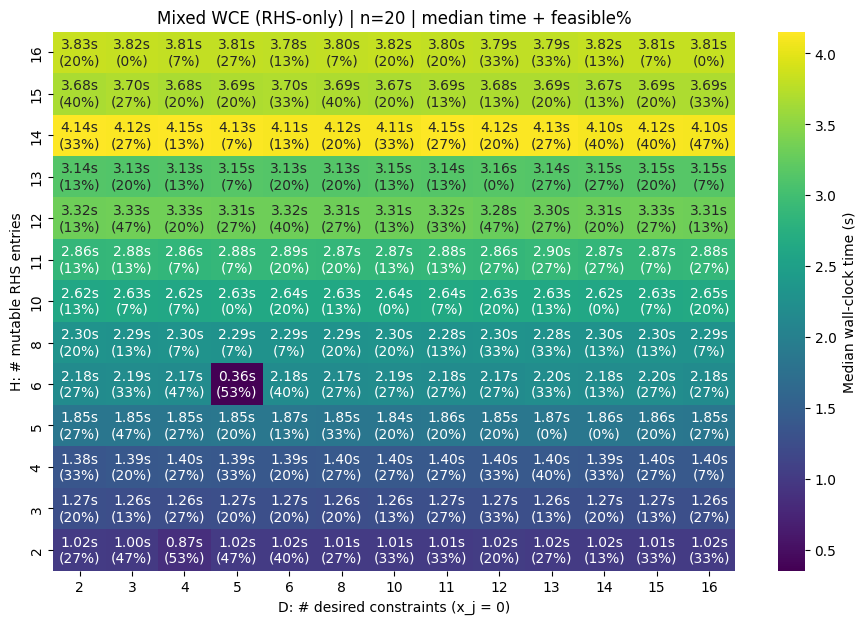

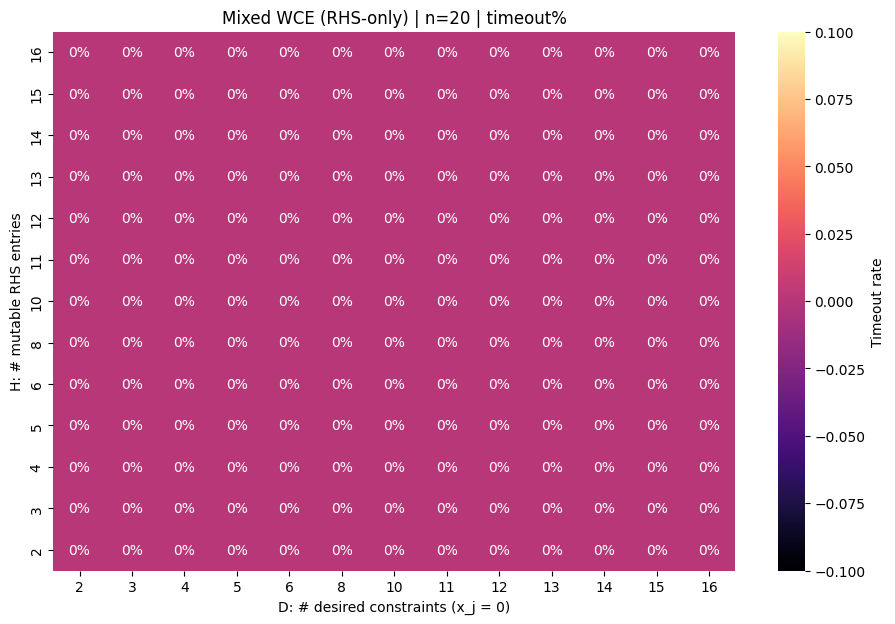

[  1/169] n=30 | H=  2 | D=  2 -> medianT=1.075s | feas=26.7% | tout=0.0%
[  2/169] n=30 | H=  2 | D=  3 -> medianT=1.075s | feas=13.3% | tout=0.0%
[  3/169] n=30 | H=  2 | D=  4 -> medianT=1.078s | feas=40.0% | tout=0.0%
[  4/169] n=30 | H=  2 | D=  5 -> medianT=1.089s | feas=26.7% | tout=0.0%
[  5/169] n=30 | H=  2 | D=  6 -> medianT=1.080s | feas=26.7% | tout=0.0%
[  6/169] n=30 | H=  2 | D=  8 -> medianT=1.079s | feas=26.7% | tout=0.0%
[  7/169] n=30 | H=  2 | D= 10 -> medianT=1.081s | feas=26.7% | tout=0.0%
[  8/169] n=30 | H=  2 | D= 11 -> medianT=1.077s | feas=33.3% | tout=0.0%
[  9/169] n=30 | H=  2 | D= 12 -> medianT=1.080s | feas=40.0% | tout=0.0%
[ 10/169] n=30 | H=  2 | D= 13 -> medianT=1.076s | feas=13.3% | tout=0.0%
[ 11/169] n=30 | H=  2 | D= 14 -> medianT=1.073s | feas=20.0% | tout=0.0%
[ 12/169] n=30 | H=  2 | D= 15 -> medianT=1.079s | feas=0.0% | tout=0.0%
[ 13/169] n=30 | H=  2 | D= 16 -> medianT=1.084s | feas=26.7% | tout=0.0%
[ 14/169] n=30 | H=  3 | D=  2 -> media

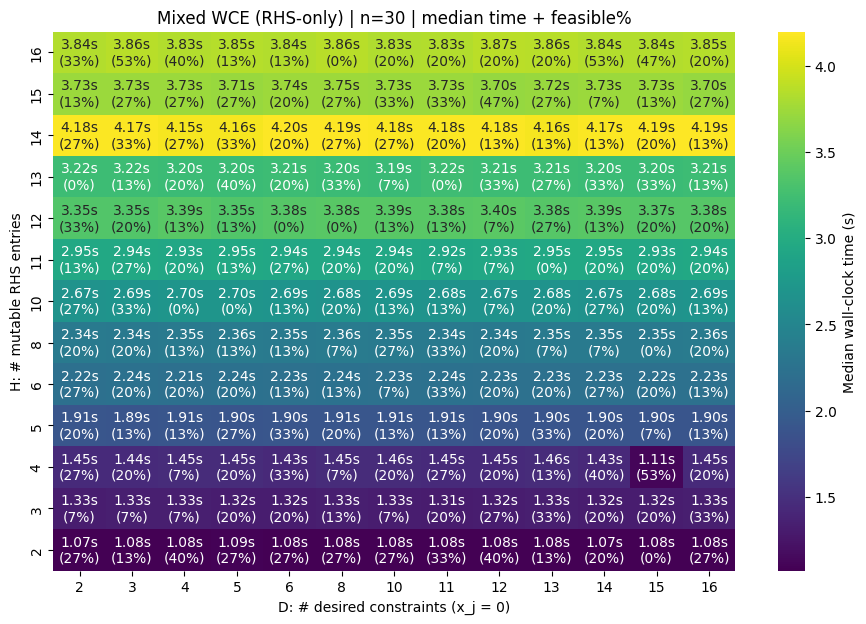

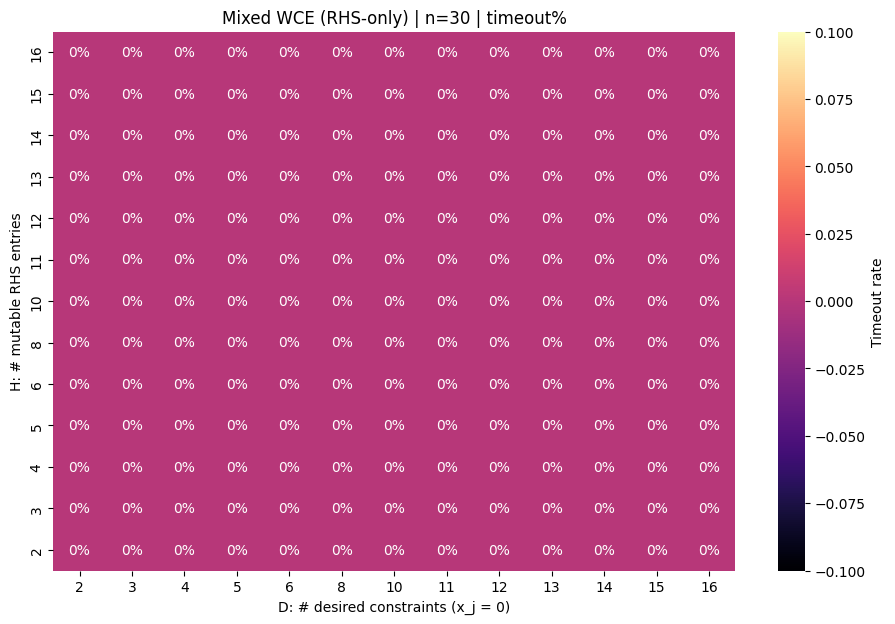

[  1/169] n=40 | H=  2 | D=  2 -> medianT=1.171s | feas=33.3% | tout=0.0%
[  2/169] n=40 | H=  2 | D=  3 -> medianT=1.159s | feas=26.7% | tout=0.0%
[  3/169] n=40 | H=  2 | D=  4 -> medianT=1.188s | feas=26.7% | tout=0.0%
[  4/169] n=40 | H=  2 | D=  5 -> medianT=1.192s | feas=6.7% | tout=0.0%
[  5/169] n=40 | H=  2 | D=  6 -> medianT=1.159s | feas=6.7% | tout=0.0%
[  6/169] n=40 | H=  2 | D=  8 -> medianT=0.991s | feas=60.0% | tout=0.0%
[  7/169] n=40 | H=  2 | D= 10 -> medianT=1.176s | feas=26.7% | tout=0.0%
[  8/169] n=40 | H=  2 | D= 11 -> medianT=1.163s | feas=33.3% | tout=0.0%
[  9/169] n=40 | H=  2 | D= 12 -> medianT=1.141s | feas=46.7% | tout=0.0%
[ 10/169] n=40 | H=  2 | D= 13 -> medianT=1.158s | feas=46.7% | tout=0.0%
[ 11/169] n=40 | H=  2 | D= 14 -> medianT=1.170s | feas=33.3% | tout=0.0%
[ 12/169] n=40 | H=  2 | D= 15 -> medianT=1.177s | feas=26.7% | tout=0.0%
[ 13/169] n=40 | H=  2 | D= 16 -> medianT=1.037s | feas=53.3% | tout=0.0%
[ 14/169] n=40 | H=  3 | D=  2 -> median

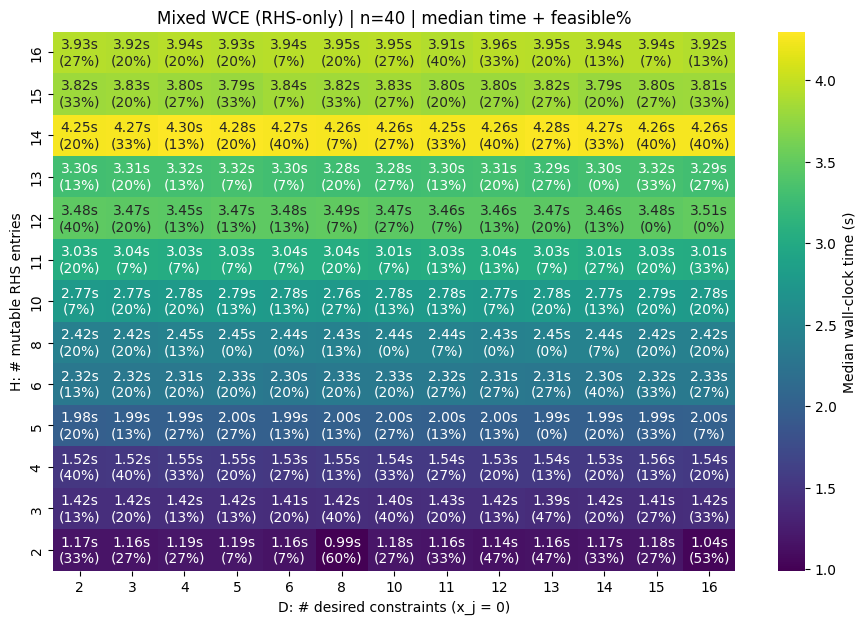

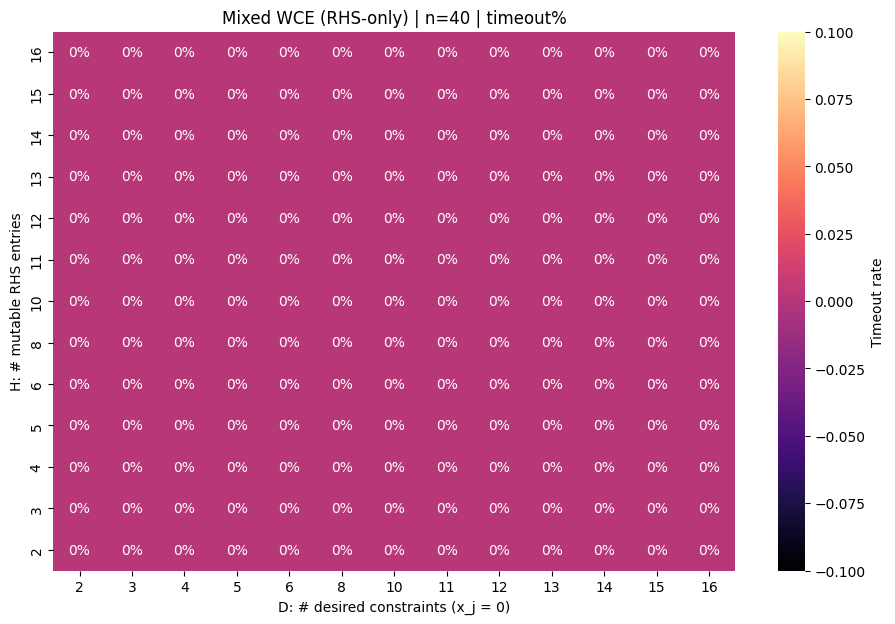

[  1/169] n=50 | H=  2 | D=  2 -> medianT=1.190s | feas=33.3% | tout=0.0%
[  2/169] n=50 | H=  2 | D=  3 -> medianT=1.173s | feas=46.7% | tout=0.0%
[  3/169] n=50 | H=  2 | D=  4 -> medianT=1.027s | feas=60.0% | tout=0.0%
[  4/169] n=50 | H=  2 | D=  5 -> medianT=1.203s | feas=26.7% | tout=0.0%
[  5/169] n=50 | H=  2 | D=  6 -> medianT=1.192s | feas=40.0% | tout=0.0%
[  6/169] n=50 | H=  2 | D=  8 -> medianT=1.195s | feas=33.3% | tout=0.0%
[  7/169] n=50 | H=  2 | D= 10 -> medianT=1.204s | feas=33.3% | tout=0.0%
[  8/169] n=50 | H=  2 | D= 11 -> medianT=1.197s | feas=33.3% | tout=0.0%
[  9/169] n=50 | H=  2 | D= 12 -> medianT=1.199s | feas=33.3% | tout=0.0%
[ 10/169] n=50 | H=  2 | D= 13 -> medianT=1.193s | feas=46.7% | tout=0.0%
[ 11/169] n=50 | H=  2 | D= 14 -> medianT=0.553s | feas=53.3% | tout=0.0%
[ 12/169] n=50 | H=  2 | D= 15 -> medianT=1.201s | feas=40.0% | tout=0.0%
[ 13/169] n=50 | H=  2 | D= 16 -> medianT=1.198s | feas=26.7% | tout=0.0%
[ 14/169] n=50 | H=  3 | D=  2 -> medi

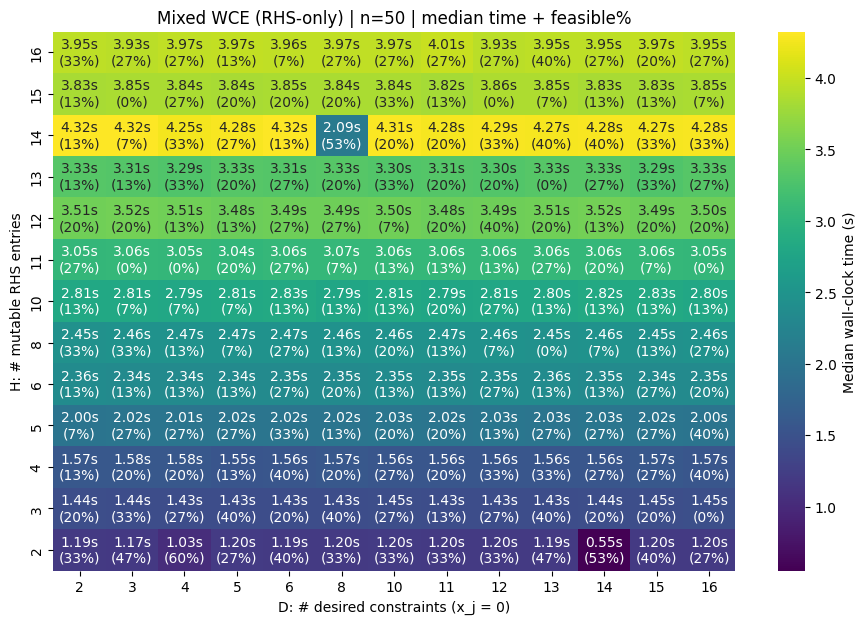

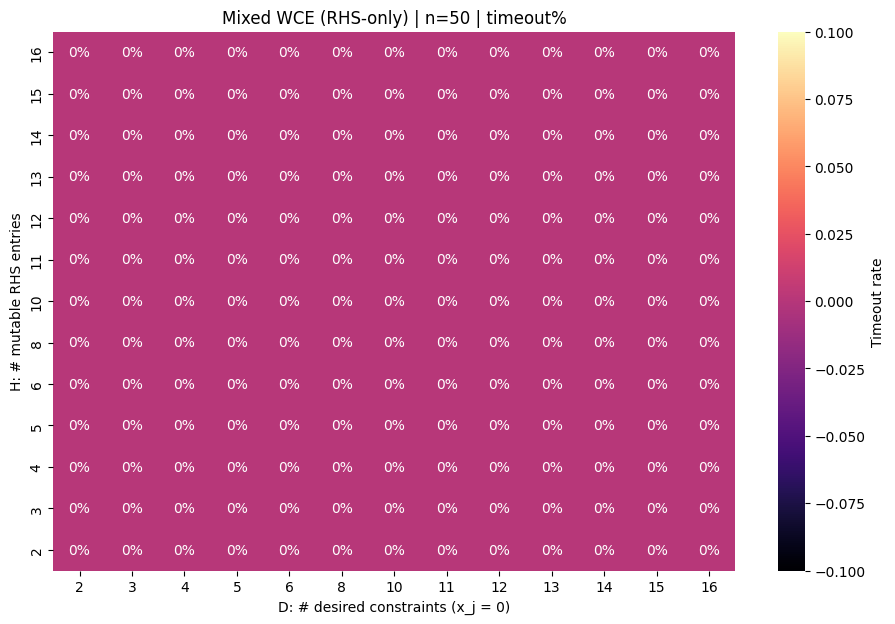

[  1/169] n=60 | H=  2 | D=  2 -> medianT=1.031s | feas=53.3% | tout=0.0%
[  2/169] n=60 | H=  2 | D=  3 -> medianT=1.278s | feas=40.0% | tout=0.0%
[  3/169] n=60 | H=  2 | D=  4 -> medianT=1.288s | feas=26.7% | tout=0.0%
[  4/169] n=60 | H=  2 | D=  5 -> medianT=1.288s | feas=20.0% | tout=0.0%
[  5/169] n=60 | H=  2 | D=  6 -> medianT=1.272s | feas=46.7% | tout=0.0%
[  6/169] n=60 | H=  2 | D=  8 -> medianT=1.289s | feas=20.0% | tout=0.0%
[  7/169] n=60 | H=  2 | D= 10 -> medianT=1.116s | feas=53.3% | tout=0.0%
[  8/169] n=60 | H=  2 | D= 11 -> medianT=1.290s | feas=46.7% | tout=0.0%
[  9/169] n=60 | H=  2 | D= 12 -> medianT=1.298s | feas=33.3% | tout=0.0%
[ 10/169] n=60 | H=  2 | D= 13 -> medianT=1.294s | feas=40.0% | tout=0.0%
[ 11/169] n=60 | H=  2 | D= 14 -> medianT=1.269s | feas=40.0% | tout=0.0%
[ 12/169] n=60 | H=  2 | D= 15 -> medianT=1.043s | feas=53.3% | tout=0.0%
[ 13/169] n=60 | H=  2 | D= 16 -> medianT=1.305s | feas=26.7% | tout=0.0%
[ 14/169] n=60 | H=  3 | D=  2 -> medi

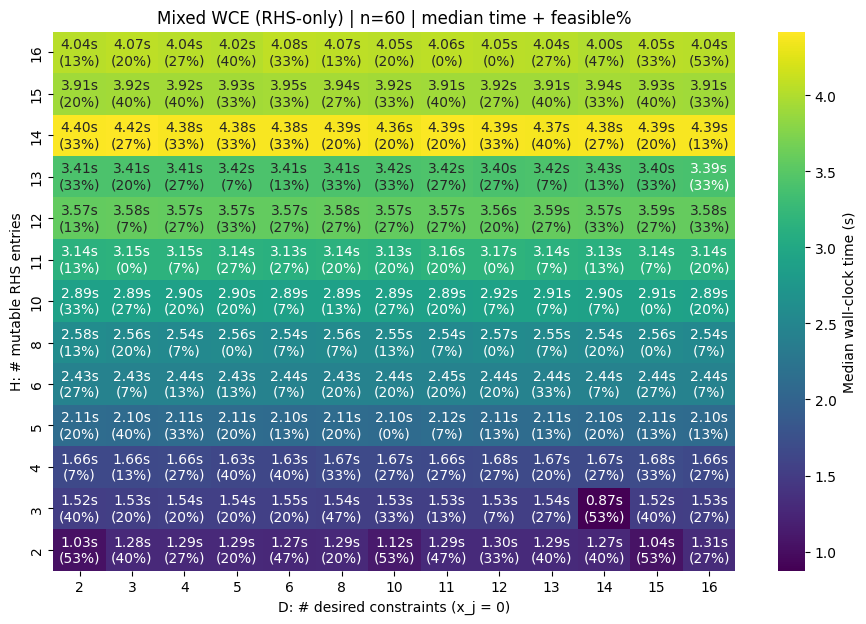

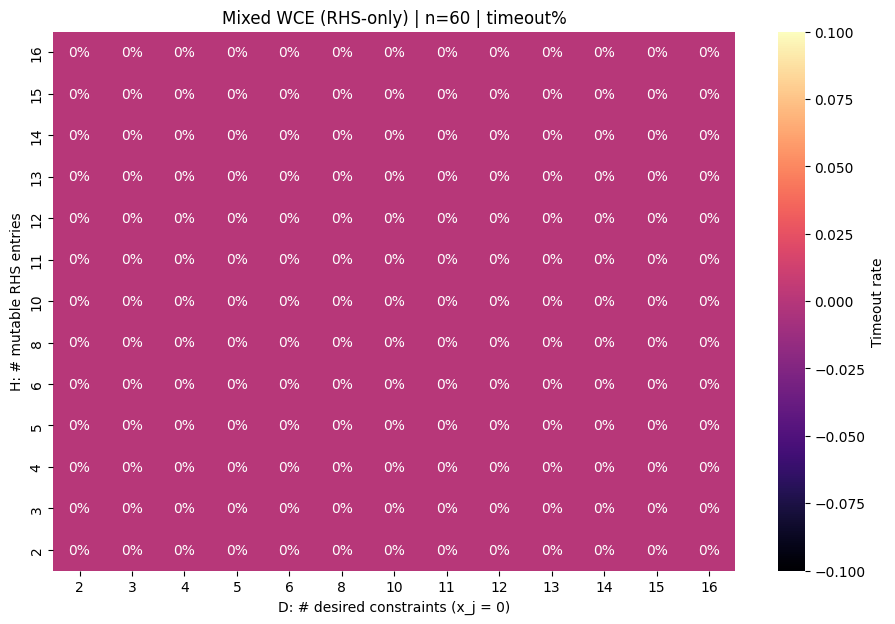

[  1/169] n=70 | H=  2 | D=  2 -> medianT=1.402s | feas=46.7% | tout=0.0%
[  2/169] n=70 | H=  2 | D=  3 -> medianT=1.405s | feas=40.0% | tout=0.0%
[  3/169] n=70 | H=  2 | D=  4 -> medianT=1.402s | feas=33.3% | tout=0.0%
[  4/169] n=70 | H=  2 | D=  5 -> medianT=1.407s | feas=40.0% | tout=0.0%
[  5/169] n=70 | H=  2 | D=  6 -> medianT=1.417s | feas=40.0% | tout=0.0%
[  6/169] n=70 | H=  2 | D=  8 -> medianT=1.406s | feas=26.7% | tout=0.0%
[  7/169] n=70 | H=  2 | D= 10 -> medianT=1.410s | feas=13.3% | tout=0.0%
[  8/169] n=70 | H=  2 | D= 11 -> medianT=1.406s | feas=26.7% | tout=0.0%
[  9/169] n=70 | H=  2 | D= 12 -> medianT=1.393s | feas=33.3% | tout=0.0%
[ 10/169] n=70 | H=  2 | D= 13 -> medianT=1.390s | feas=46.7% | tout=0.0%
[ 11/169] n=70 | H=  2 | D= 14 -> medianT=1.401s | feas=40.0% | tout=0.0%
[ 12/169] n=70 | H=  2 | D= 15 -> medianT=1.406s | feas=26.7% | tout=0.0%
[ 13/169] n=70 | H=  2 | D= 16 -> medianT=1.395s | feas=46.7% | tout=0.0%
[ 14/169] n=70 | H=  3 | D=  2 -> medi

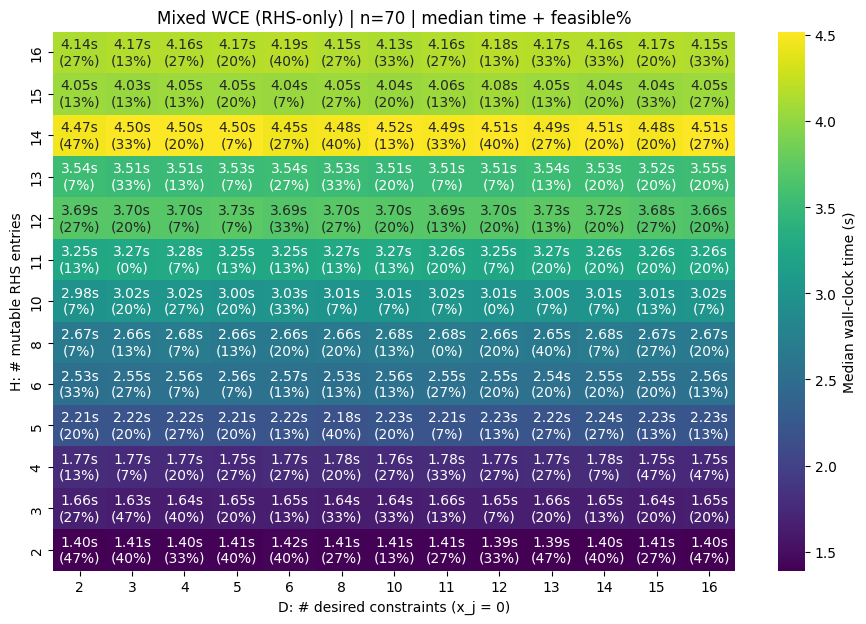

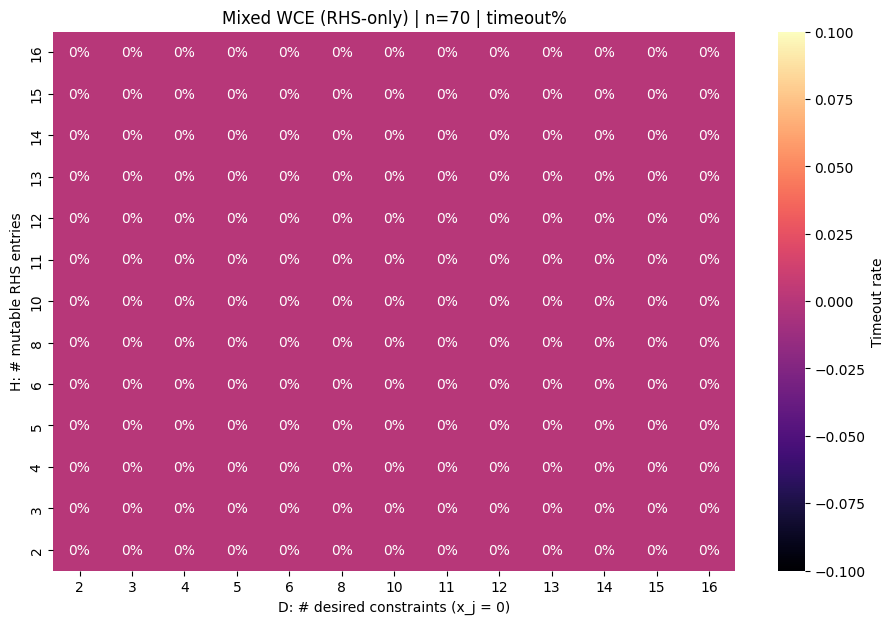

[  1/169] n=80 | H=  2 | D=  2 -> medianT=1.533s | feas=33.3% | tout=0.0%
[  2/169] n=80 | H=  2 | D=  3 -> medianT=1.496s | feas=33.3% | tout=0.0%
[  3/169] n=80 | H=  2 | D=  4 -> medianT=1.506s | feas=33.3% | tout=0.0%
[  4/169] n=80 | H=  2 | D=  5 -> medianT=1.507s | feas=40.0% | tout=0.0%
[  5/169] n=80 | H=  2 | D=  6 -> medianT=1.506s | feas=26.7% | tout=0.0%
[  6/169] n=80 | H=  2 | D=  8 -> medianT=1.522s | feas=26.7% | tout=0.0%
[  7/169] n=80 | H=  2 | D= 10 -> medianT=1.486s | feas=46.7% | tout=0.0%
[  8/169] n=80 | H=  2 | D= 11 -> medianT=1.512s | feas=33.3% | tout=0.0%
[  9/169] n=80 | H=  2 | D= 12 -> medianT=1.510s | feas=33.3% | tout=0.0%
[ 10/169] n=80 | H=  2 | D= 13 -> medianT=1.525s | feas=26.7% | tout=0.0%
[ 11/169] n=80 | H=  2 | D= 14 -> medianT=1.515s | feas=26.7% | tout=0.0%
[ 12/169] n=80 | H=  2 | D= 15 -> medianT=1.508s | feas=46.7% | tout=0.0%
[ 13/169] n=80 | H=  2 | D= 16 -> medianT=1.515s | feas=33.3% | tout=0.0%
[ 14/169] n=80 | H=  3 | D=  2 -> medi

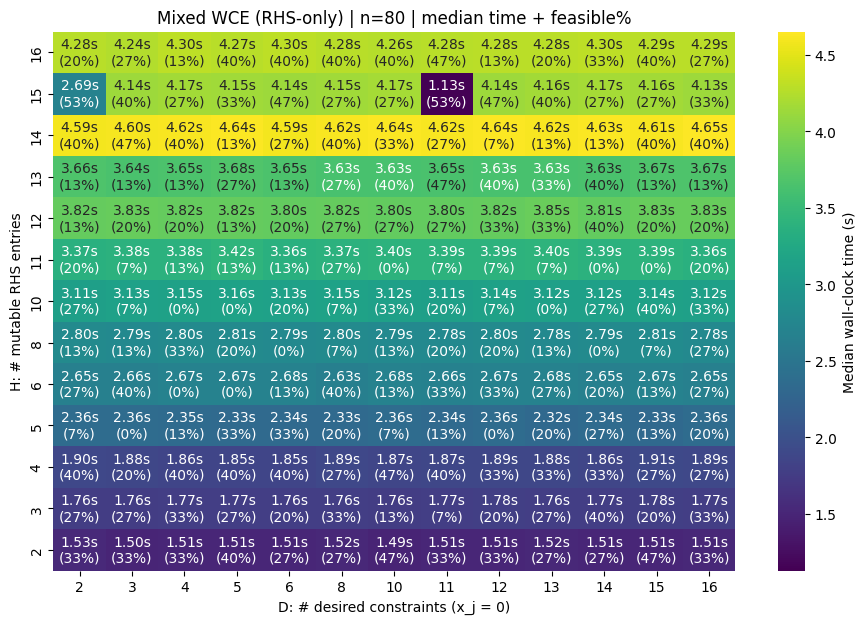

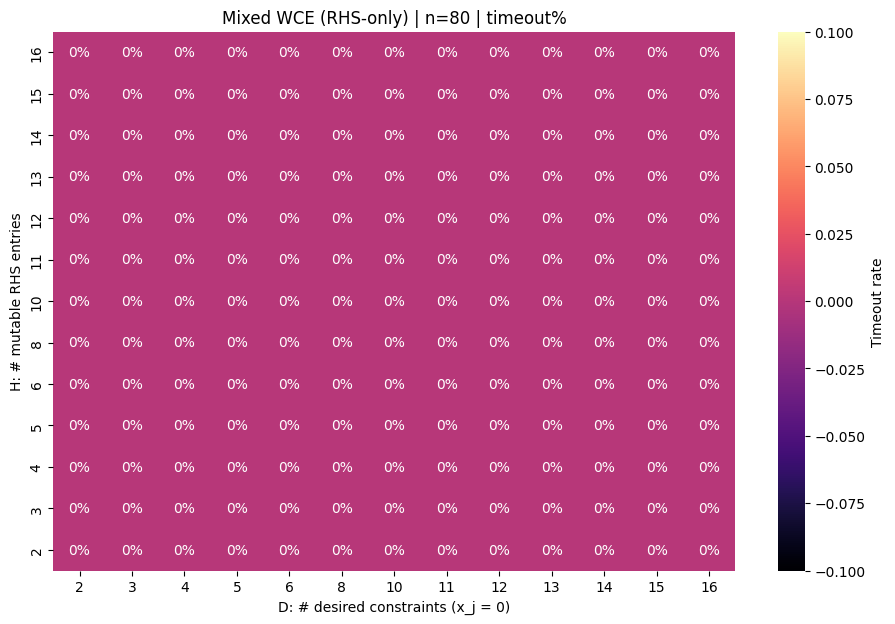

[  1/169] n=90 | H=  2 | D=  2 -> medianT=1.475s | feas=53.3% | tout=0.0%
[  2/169] n=90 | H=  2 | D=  3 -> medianT=1.655s | feas=33.3% | tout=0.0%
[  3/169] n=90 | H=  2 | D=  4 -> medianT=1.641s | feas=46.7% | tout=0.0%
[  4/169] n=90 | H=  2 | D=  5 -> medianT=1.674s | feas=26.7% | tout=0.0%
[  5/169] n=90 | H=  2 | D=  6 -> medianT=1.666s | feas=6.7% | tout=0.0%
[  6/169] n=90 | H=  2 | D=  8 -> medianT=1.654s | feas=33.3% | tout=0.0%
[  7/169] n=90 | H=  2 | D= 10 -> medianT=1.637s | feas=20.0% | tout=0.0%
[  8/169] n=90 | H=  2 | D= 11 -> medianT=1.629s | feas=33.3% | tout=0.0%
[  9/169] n=90 | H=  2 | D= 12 -> medianT=1.451s | feas=53.3% | tout=0.0%
[ 10/169] n=90 | H=  2 | D= 13 -> medianT=1.651s | feas=40.0% | tout=0.0%
[ 11/169] n=90 | H=  2 | D= 14 -> medianT=1.649s | feas=40.0% | tout=0.0%
[ 12/169] n=90 | H=  2 | D= 15 -> medianT=1.463s | feas=53.3% | tout=0.0%
[ 13/169] n=90 | H=  2 | D= 16 -> medianT=1.329s | feas=66.7% | tout=0.0%
[ 14/169] n=90 | H=  3 | D=  2 -> media

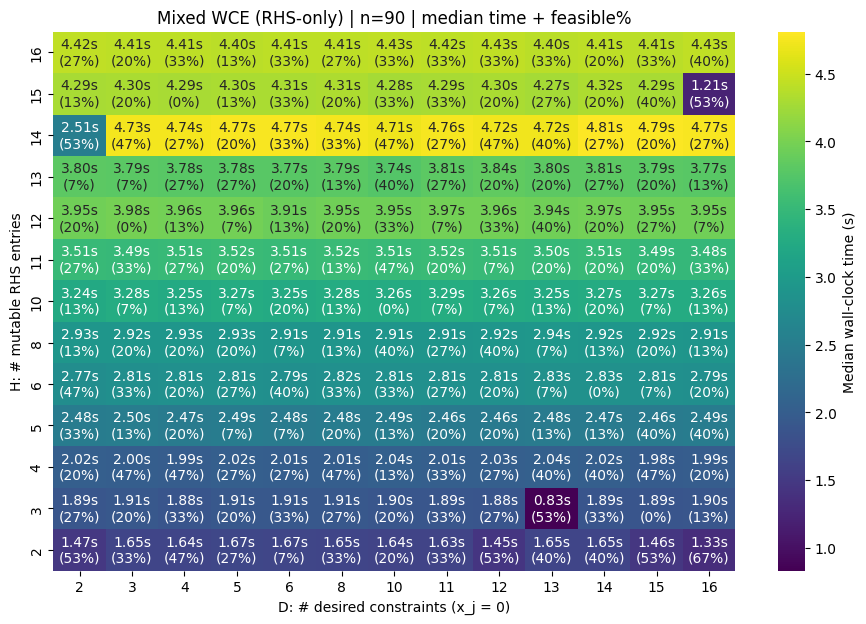

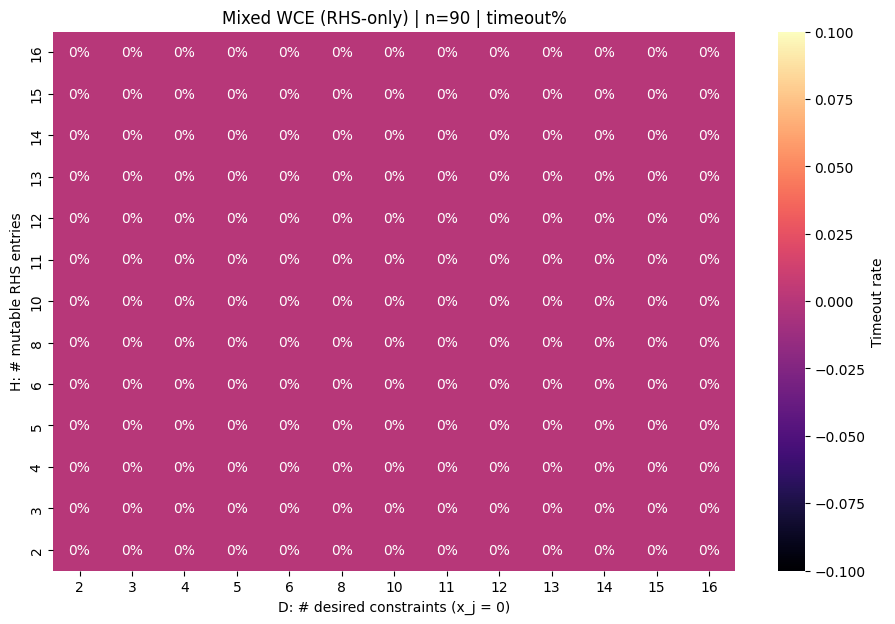

[  1/169] n=100 | H=  2 | D=  2 -> medianT=1.796s | feas=40.0% | tout=0.0%
[  2/169] n=100 | H=  2 | D=  3 -> medianT=1.788s | feas=46.7% | tout=0.0%
[  3/169] n=100 | H=  2 | D=  4 -> medianT=0.890s | feas=60.0% | tout=0.0%
[  4/169] n=100 | H=  2 | D=  5 -> medianT=1.798s | feas=40.0% | tout=0.0%
[  5/169] n=100 | H=  2 | D=  6 -> medianT=1.861s | feas=26.7% | tout=0.0%
[  6/169] n=100 | H=  2 | D=  8 -> medianT=1.808s | feas=33.3% | tout=0.0%
[  7/169] n=100 | H=  2 | D= 10 -> medianT=1.578s | feas=60.0% | tout=0.0%
[  8/169] n=100 | H=  2 | D= 11 -> medianT=1.796s | feas=40.0% | tout=0.0%
[  9/169] n=100 | H=  2 | D= 12 -> medianT=1.798s | feas=26.7% | tout=0.0%
[ 10/169] n=100 | H=  2 | D= 13 -> medianT=1.569s | feas=53.3% | tout=0.0%
[ 11/169] n=100 | H=  2 | D= 14 -> medianT=1.583s | feas=53.3% | tout=0.0%
[ 12/169] n=100 | H=  2 | D= 15 -> medianT=0.901s | feas=66.7% | tout=0.0%
[ 13/169] n=100 | H=  2 | D= 16 -> medianT=1.459s | feas=60.0% | tout=0.0%
[ 14/169] n=100 | H=  3 |

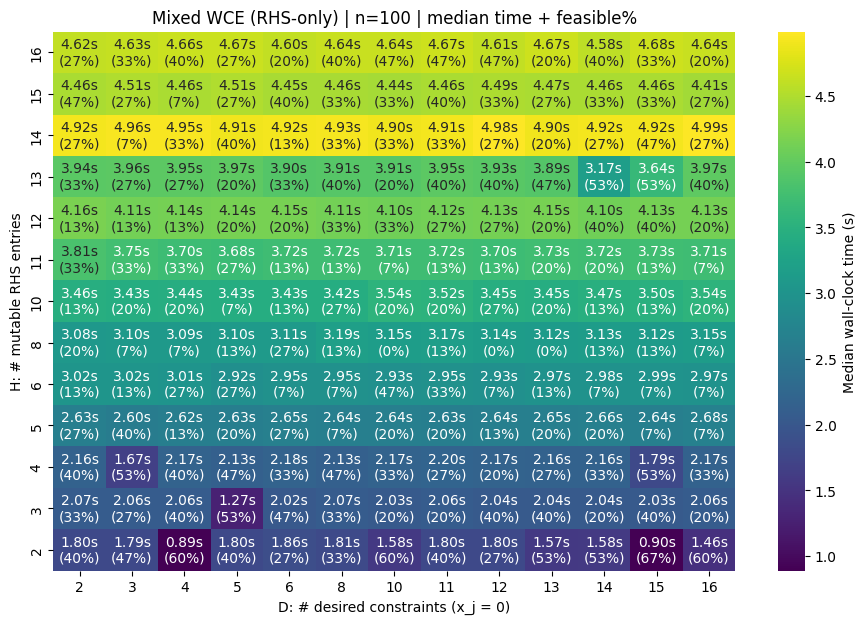

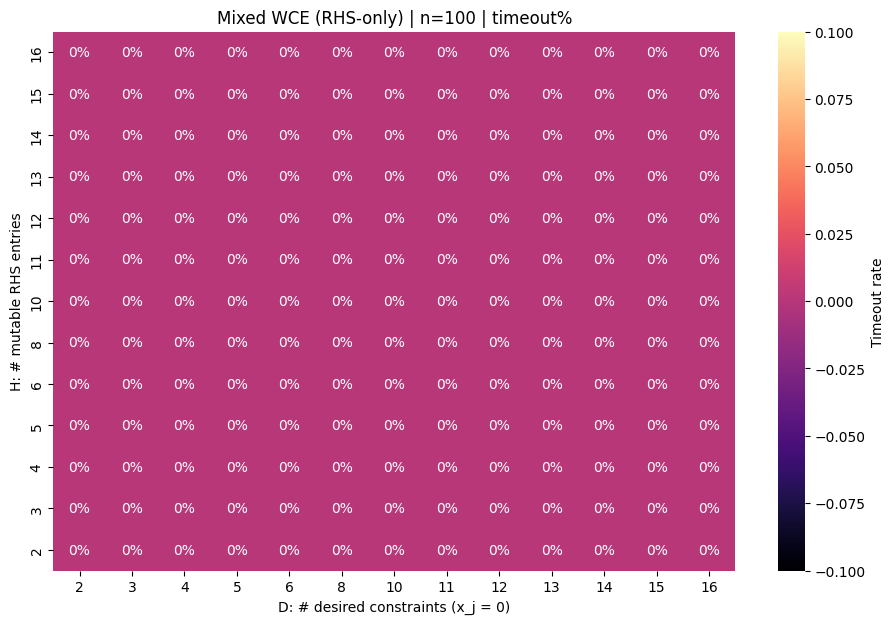

In [8]:
    # =========================
    # RUN THE EXPERIMENT (one n)
    # =========================

    # Choose one problem size first to validate everything
N=[20,30,40,50,60,70,80,90,100]
H_values = [2, 3, 4, 5, 6, 8, 10,11,12,13,14,15,16]     # # mutable RHS entries
D_values = [2, 3, 4, 5, 6, 8, 10,11,12,13,14,15,16] 

for n in N:
    # Grid values (example)
    # # forced-to-zero decision vars
    # Repeats per cell (start small; increase later)REPEATS = 5
        REPEATS = 15

        time_mat, feas_mat, tout_mat = run_grid_for_n(
            n=n,
            H_values=H_values,
            D_values=D_values,
            repeats=REPEATS,
            max_iter=50,
            time_limit=120.0,
            delta_lb=-5,
            delta_ub=5,
            m_ratio=0.8,
            base_seed=42,
            threads=1,
            master_output=0,
            oracle_output=0
        )

        plot_time_feas_heatmap(
            time_mat, feas_mat, H_values, D_values,
            title=f"Mixed WCE (RHS-only) | n={n} | median time + feasible%"
        )

        plot_timeout_heatmap(
            tout_mat, H_values, D_values,
            title=f"Mixed WCE (RHS-only) | n={n} | timeout%"
        )


# Estudio Temporal

In [ ]:
def generate_instance_standard_milp(
    n: int,
    seed: int,
    m_ratio: float = 0.8,
    force_binary_preference: bool = True,
) -> StandardFormMILP:
    """
    Generates a feasible MILP instance in your StandardFormMILP format with:
      - c in [1,25] with 2 decimals
      - A integer in [1,10]
      - b integer in [1,5]
      - 50/50 continuous and binary variables
      - constraints: A x >= b

    Feasibility guarantee:
      For each row i, we regenerate A[i,:] until max_j A[i,j] >= b_i.
      Then there exists a feasible solution by setting (at least) those argmax vars to 1.

    Optional:
      If force_binary_preference=True, we bias binary columns to have larger A coefficients
      (still within [1,10]) so binaries are more likely to be active in the forward optimum.
    """
    rng = np.random.RandomState(seed)

    # Variable types: 50/50
    n_c = n // 2
    n_b = n - n_c
    vtype = ["C"] * n_c + ["B"] * n_b

    # Bounds: all in [0,1] (works for both C and B)
    lb = np.zeros(n, dtype=float)
    ub = np.ones(n, dtype=float)

    # Number of constraints
    m = max(1, int(round(m_ratio * n)))

    # Objective coefficients c: [1,25] with 2 decimals
    c = np.round(rng.uniform(1.0, 25.0, size=n), 2)

    # RHS b: integers in [1,5]
    b = rng.randint(1, 6, size=m).astype(float)

    # Build A row-by-row with feasibility guarantee
    A = np.zeros((m, n), dtype=float)

    # Optional bias: make binary columns "stronger" in constraints (still 1..10)
    # This helps ensure forward solutions often use binaries (useful for D targets).
    if force_binary_preference and n_b > 0:
        cont_low, cont_high = 1, 7   # continuous columns: 1..6
        bin_low, bin_high   = 5, 11  # binary columns: 5..10
    else:
        cont_low, cont_high = 1, 11
        bin_low, bin_high   = 1, 11

    for i in range(m):
        bi = int(b[i])

        while True:
            row = np.empty(n, dtype=int)
            # continuous part
            row[:n_c] = rng.randint(cont_low, cont_high, size=n_c)
            # binary part
            row[n_c:] = rng.randint(bin_low, bin_high, size=n_b) if n_b > 0 else np.array([], dtype=int)

            # Feasibility guarantee for this row
            if row.max() >= bi:
                A[i, :] = row.astype(float)
                break

    sense = [">="] * m

    return StandardFormMILP(A=A, b=b, sense=sense, c=c, lb=lb, ub=ub, vtype=vtype)



In [ ]:
def make_rhs_only_spec(m: int, H: int, seed: int, delta_lb: int = -5, delta_ub: int = 5) -> MutableSpec:
    rng = np.random.RandomState(seed)
    H = int(min(max(H, 0), m))
    b_idx = rng.choice(np.arange(m), size=H, replace=False).tolist()
    return MutableSpec(b_idx=b_idx, c_idx=[], A_idx=[], delta_lb=delta_lb, delta_ub=delta_ub)


In [ ]:
def choose_targets_from_forward(x_star: np.ndarray, vtype: List[str], D: int, seed: int) -> List[int]:
    rng = np.random.RandomState(seed)
    n = len(x_star)

    # Prefer binaries that are 1 in the forward solution
    active_bin = [j for j in range(n) if vtype[j] == "B" and x_star[j] > 0.5]

    # Fallback: any variable that is > 1e-6
    active_any = [j for j in range(n) if x_star[j] > 1e-6]

    pool = active_bin if len(active_bin) > 0 else active_any
    if len(pool) == 0:
        # extreme fallback: choose any binaries
        pool = [j for j in range(n) if vtype[j] == "B"]
        if len(pool) == 0:
            pool = list(range(n))

    D = int(min(max(D, 0), n, len(pool)))
    return rng.choice(pool, size=D, replace=False).tolist()


In [ ]:
def make_desired_cb_force_zero(target_indices: List[int]):
    def desired_cb(model: gp.Model, xvars: List[gp.Var], constrs: List[gp.Constr]):
        for j in target_indices:
            model.addConstr(xvars[j] == 0.0, name=f"desired_x0[{j}]")
    return desired_cb


In [ ]:
import time

def run_time_characterization(
    n_list: List[int],
    H_values: List[int],
    D_values: List[int],
    repeats: int = 10,
    max_iter: int = 50,
    time_limit: Optional[float] = 120.0,   # set None if you refuse time limits
    delta_lb: int = -5,
    delta_ub: int = 5,
    alpha_m: float = 0.8,
    base_seed: int = 42,
    master_output: int = 0,
    oracle_output: int = 0,
):
    rows = []

    for n in n_list:
        for H in H_values:
            for D in D_values:

                times = []
                feasible = 0
                timeouts = 0
                errors = 0

                for r in range(repeats):
                    seed = base_seed + 100000*n + 1000*H + 10*D + r

                    # 1) instance
                    base = generate_instance_standard_milp(n=n, seed=seed, alpha_m=alpha_m)
                    m = base.A.shape[0]

                    # 2) RHS-only mutable spec with |b_idx|=H
                    spec = make_rhs_only_spec(m=m, H=H, seed=seed+7, delta_lb=delta_lb, delta_ub=delta_ub)

                    # 3) forward solve to pick targets
                    theta0, x0 = solve_forward_only(base, base.A, base.b, base.c, output_flag=0)
                    if x0 is None:
                        errors += 1
                        continue

                    target_idx = choose_targets_from_forward(x0, base.vtype, D=D, seed=seed+13)
                    desired_cb = make_desired_cb_force_zero(target_idx)

                    # 4) time the whole WCE call
                    t0 = time.perf_counter()
                    try:
                        best = solve_wce_general(
                            base=base,
                            spec=spec,
                            desired_space_cb=desired_cb,
                            max_iter=max_iter,
                            tol=0.0,
                            master_output=master_output,
                            oracle_output=oracle_output
                        )
                        dt = time.perf_counter() - t0
                    except Exception:
                        dt = time.perf_counter() - t0
                        best = None
                        errors += 1

                    times.append(dt)

                    if best is not None:
                        feasible += 1

                    # If you implement TimeLimit propagation + status capture,
                    # this is where you increment `timeouts`.

                # aggregate (use medians for MILP)
                if len(times) == 0:
                    med_t = float("nan")
                    p25 = float("nan")
                    p75 = float("nan")
                else:
                    med_t = float(np.median(times))
                    p25 = float(np.percentile(times, 25))
                    p75 = float(np.percentile(times, 75))

                rows.append({
                    "n": n,
                    "m": int(round(alpha_m*n)),
                    "H": H,
                    "D": D,
                    "repeats": repeats,
                    "median_time_s": med_t,
                    "p25_time_s": p25,
                    "p75_time_s": p75,
                    "feasible_pct": feasible / repeats,
                    "error_pct": errors / repeats,
                    # "timeout_pct": timeouts / repeats,  # enable once TimeLimit is plumbed through
                })

    return rows


# Knaapsack

# Novo intento

In [82]:
from dataclasses import dataclass
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# -----------------------------
# Data
# -----------------------------
@dataclass(frozen=True)
class MixedKnapsackInstance:
    n: int
    a: np.ndarray       # coverage coefficients (n,)
    c: np.ndarray       # variable cost on x (n,)
    f: np.ndarray       # fixed cost on y (n,)
    B0: float           # base RHS "demand"

@dataclass(frozen=True)
class RHSOnlySpec:
    db_lb: int
    db_ub: int
    l1_weight: float = 1.0


# -----------------------------
# Follower MILP (forward oracle)
# -----------------------------
def solve_forward_mixed_knapsack(inst: MixedKnapsackInstance, B: float, output_flag: int = 0):
    """
    Solve follower MILP:
      min c^T x + f^T y
      s.t. a^T x >= B
           0 <= x_i <= y_i
           y_i binary
    Returns: obj, y_pat, x, status
    """
    n = inst.n
    m = gp.Model("MK_forward")
    m.Params.OutputFlag = output_flag

    x = m.addVars(n, lb=0.0, name="x")
    y = m.addVars(n, vtype=GRB.BINARY, name="y")

    m.setObjective(
        gp.quicksum(inst.c[i] * x[i] for i in range(n)) +
        gp.quicksum(inst.f[i] * y[i] for i in range(n)),
        GRB.MINIMIZE
    )

    m.addConstr(gp.quicksum(inst.a[i] * x[i] for i in range(n)) >= float(B), name="cover")

    for i in range(n):
        m.addConstr(x[i] <= y[i], name=f"link[{i}]")

    m.optimize()
    if m.Status != GRB.OPTIMAL:
        return {"status": m.Status}

    y_pat = tuple(int(round(y[i].X)) for i in range(n))
    x_sol = np.array([x[i].X for i in range(n)], dtype=float)
    return {"status": m.Status, "obj": float(m.ObjVal), "y_pat": y_pat, "x": x_sol}


# -----------------------------
# Witness existence at theta (WCE check)
# -----------------------------
def witness_exists_at_theta_mk(inst: MixedKnapsackInstance, B: float, theta: float, desired_cb,
                               tol: float = 1e-6, output_flag: int = 0):
    """
    Feasibility MILP:
      find (x,y) in desired region s.t. follower constraints at B and objective <= theta+tol
    """
    n = inst.n
    m = gp.Model("MK_witness")
    m.Params.OutputFlag = output_flag

    x = m.addVars(n, lb=0.0, name="xW")
    y = m.addVars(n, vtype=GRB.BINARY, name="yW")

    obj_expr = (
        gp.quicksum(inst.c[i] * x[i] for i in range(n)) +
        gp.quicksum(inst.f[i] * y[i] for i in range(n))
    )

    m.setObjective(0.0, GRB.MINIMIZE)

    m.addConstr(gp.quicksum(inst.a[i] * x[i] for i in range(n)) >= float(B), name="cover")
    for i in range(n):
        m.addConstr(x[i] <= y[i], name=f"link[{i}]")

    desired_cb(m, x, y)

    m.addConstr(obj_expr <= float(theta) + float(tol), name="within_theta")

    m.optimize()
    if m.Status == GRB.OPTIMAL:
        y_sol = np.array([int(round(y[i].X)) for i in range(n)], dtype=int)
        obj_val = sum(inst.c[i] * x[i].X for i in range(n)) + sum(inst.f[i] * y[i].X for i in range(n))
        return {"feasible": True, "status": m.Status, "y": y_sol, "obj": float(obj_val)}
    return {"feasible": False, "status": m.Status}


# -----------------------------
# Fixed-pattern LP for OA cut
# -----------------------------
def solve_fixed_y_lp_get_cutdata(inst: MixedKnapsackInstance, Bk: float, y_pat, output_flag: int = 0):
    """
    Fix y=y_pat, solve LP in x:
      min c^T x + f^T y_pat
      s.t. a^T x >= Bk
           0 <= x_i <= y_pat[i]
    For minimization with RHS B in a^T x >= B:
      Vu(B) is convex increasing; a valid subgradient is pi >= 0 (dual on cover constraint).
    OA cut at Bk:
      Vu(B) >= Vu(Bk) + pi*(B - Bk)
    """
    n = inst.n
    y_pat = tuple(int(v) for v in y_pat)

    m = gp.Model("MK_fixed_y_LP")
    m.Params.OutputFlag = output_flag

    x = m.addVars(n, lb=0.0, name="x")

    fixed_term = float(np.dot(inst.f, np.array(y_pat, dtype=float)))
    m.setObjective(gp.quicksum(inst.c[i] * x[i] for i in range(n)) + fixed_term, GRB.MINIMIZE)

    cover_con = m.addConstr(gp.quicksum(inst.a[i] * x[i] for i in range(n)) >= float(Bk), name="cover")

    for i in range(n):
        m.addConstr(x[i] <= float(y_pat[i]), name=f"ub[{i}]")

    m.optimize()
    if m.Status != GRB.OPTIMAL:
        return {"status": m.Status, "y_pat": y_pat}

    Vu = float(m.ObjVal)

    # Dual for >= constraint in Gurobi is typically <= 0 (depends on convention).
    # We want pi >= 0 as subgradient of Vu wrt B.
    # For constraint a^T x >= B, the Lagrange multiplier lambda should be >= 0.
    # Gurobi's Pi for a >= constraint is usually <= 0, so take pi = -Pi.
    pi =  float(cover_con.Pi)
    print(f"[CUT] y={y_pat} Bk={Bk} Vu={Vu:.6f} pi={pi:.6f}")

    return {"status": m.Status, "Vu": Vu, "pi": pi, "Bk": float(Bk), "y_pat": y_pat}


# -----------------------------
# Master (OA-WCE relaxation)
# -----------------------------
def build_master_mk_rhs_only(inst: MixedKnapsackInstance, spec: RHSOnlySpec, desired_cb,
                             tracked_patterns, cuts_by_pattern,
                             output_flag: int = 0, BIG_M_L1: float = 1e6):

    n = inst.n
    m = gp.Model("MK_master")
    m.Params.OutputFlag = output_flag

    # integer db + abs
    db = m.addVar(vtype=GRB.INTEGER, lb=spec.db_lb, ub=spec.db_ub, name="db")
    adb = m.addVar(lb=0.0, name="adb")
    m.addConstr(adb >= db, name="abs1")
    m.addConstr(adb >= -db, name="abs2")

    # B = B0 + db
    B = m.addVar(lb=-GRB.INFINITY, name="B")
    m.addConstr(B == float(inst.B0) + db, name="Bdef")

    # Witness variables
    xW = m.addVars(n, lb=0.0, name="xW")
    yW = m.addVars(n, vtype=GRB.BINARY, name="yW")

    witness_obj = (
        gp.quicksum(inst.c[i] * xW[i] for i in range(n)) +
        gp.quicksum(inst.f[i] * yW[i] for i in range(n))
    )

    # Witness feasibility (same follower constraints)
    m.addConstr(gp.quicksum(inst.a[i] * xW[i] for i in range(n)) >= B, name="W_cover")
    for i in range(n):
        m.addConstr(xW[i] <= yW[i], name=f"W_link[{i}]")

    desired_cb(m, xW, yW)

    # ---- Value-function lower bounds for each tracked pattern ----
    # ---- Lower bound on theta(B) via upper-bounding OA cuts ----
    theta_lb = m.addVar(lb=-GRB.INFINITY, name="theta_lb")
    num_cuts = 0

    for y_pat in tracked_patterns:
        key = tuple(int(v) for v in y_pat)

        # feasibility domain for fixed-y LP: max coverage is sum a_i*y_i
        cap_y = float(np.dot(inst.a, np.array(key, dtype=float)))

        # Slack that measures how much B exceeds this pattern's max coverage.
        # If B <= cap_y, then slack can be 0 and the cut is enforced tightly.
        # If B > cap_y, slack must be >= (B - cap_y) and the cut is relaxed.
        s_infeas = m.addVar(lb=0.0, name=f"s_infeas[{','.join(map(str,key))}]")
        m.addConstr(s_infeas >= B - cap_y, name=f"cap_slack[{','.join(map(str,key))}]")

        for j, cut in enumerate(cuts_by_pattern.get(key, [])):
            Vu = float(cut["Vu"])
            pi = float(cut["pi"])
            Bk = float(cut["Bk"])
            m.addConstr(
                theta_lb <= Vu + pi * (B - Bk) + BIG_M_L1 * s_infeas,
                name=f"theta_le_l[{','.join(map(str,key))},{j}]"
            )
            num_cuts += 1


    if num_cuts == 0:
        m.addConstr(0 >= 1, name="no_cuts")

    # WCE relaxation
    m.addConstr(witness_obj <= theta_lb, name="witness_le_theta_lb")


    # Objective: minimize L1, tie-break maximize theta_lb
    m.setObjective(float(BIG_M_L1) * float(spec.l1_weight) * adb - theta_lb, GRB.MINIMIZE)

    return {
        "model": m,
        "db": db,
        "adb": adb,
        "B": B,
        "xW": xW,
        "yW": yW,
        "witness_obj": witness_obj,
        "theta_lb": theta_lb,
    }



# -----------------------------
# OA loop
# -----------------------------
def wce_oa_mk_rhs_only(inst: MixedKnapsackInstance, spec: RHSOnlySpec, desired_cb,
                       max_iter: int = 50, tol: float = 1e-6,
                       master_output: int = 0, oracle_output: int = 0,
                       print_iters: int = 10):

    B0 = float(inst.B0)

    # forward at B0
    fwd0 = solve_forward_mixed_knapsack(inst, B0, output_flag=oracle_output)
    # --- CONSISTENCY CHECK (MUST HOLD) ---
    cut0 = solve_fixed_y_lp_get_cutdata(inst, B0, fwd0["y_pat"], output_flag=oracle_output)
    print("[CONSISTENCY] B0 =", B0)
    print("[CONSISTENCY] fwd0 y =", fwd0["y_pat"], "theta =", float(fwd0["obj"]))
    print("[CONSISTENCY] fixed-y Vu =", cut0.get("Vu"), "pi =", cut0.get("pi"), "status =", cut0.get("status"))
    x = fwd0["x"]
    y = fwd0["y_pat"]
    obj_manual = float(np.dot(inst.c, x) + np.dot(inst.f, np.array(y)))
    print("[MANUAL OBJ]", obj_manual, "solver obj", fwd0["obj"])

    if fwd0.get("status") != GRB.OPTIMAL:
        return None

    tracked_patterns = set()
    cuts_by_pattern = {}

    def add_pattern_and_cut(y_pat, Bk):
        y_pat = tuple(int(v) for v in y_pat)
        if y_pat not in tracked_patterns:
            tracked_patterns.add(y_pat)
            cuts_by_pattern[y_pat] = []
        cut = solve_fixed_y_lp_get_cutdata(inst, Bk, y_pat, output_flag=oracle_output)
        if cut.get("status") == GRB.OPTIMAL:
            cuts_by_pattern[y_pat].append(cut)
            return True
        return False

    # seed
    add_pattern_and_cut(fwd0["y_pat"], B0)

    for it in range(1, max_iter + 1):
        pack = build_master_mk_rhs_only(
            inst, spec, desired_cb,
            tracked_patterns=sorted(tracked_patterns),
            cuts_by_pattern=cuts_by_pattern,
            output_flag=master_output
        )
        m = pack["model"]
        m.optimize()

        if m.Status in (GRB.INF_OR_UNBD,):
            # disambiguate
            m.Params.DualReductions = 0
            m.optimize()

        if m.Status != GRB.OPTIMAL:
            # write IIS if infeasible
            if m.Status == GRB.INFEASIBLE:
                try:
                    m.computeIIS()
                    m.write("mk_master_iis.ilp")
                except:
                    pass
            if it <= print_iters:
                print(f"[MASTER] it={it} status={m.Status}")
            return None

        Bcand = float(pack["B"].X)
        dbcand = int(round(pack["db"].X))
        theta_lb = float(pack["theta_lb"].X)

        fwd = solve_forward_mixed_knapsack(inst, Bcand, output_flag=oracle_output)
        if fwd.get("status") != GRB.OPTIMAL:
            return None
        theta = float(fwd["obj"])

        wit = witness_exists_at_theta_mk(inst, Bcand, theta, desired_cb, tol=tol, output_flag=oracle_output)

        if it <= print_iters:
            print(f"[IT {it}] db={dbcand}  B={Bcand:.6f}  theta_lb={theta_lb:.6f}  "
                f"fwd_y={fwd['y_pat']}  theta={theta:.6f}  wit={wit['feasible']}  "
                f"|tracked|={len(tracked_patterns)}")


        if wit["feasible"]:
            return {
                "iterations": it,
                "db": dbcand,
                "B": Bcand,
                "theta": theta,
                "theta_lb": theta_lb,
                "forward": fwd,
                "witness": wit,
                "tracked_patterns": sorted(tracked_patterns)
            }

        # add the newly observed forward pattern cut at Bcand
        add_pattern_and_cut(fwd["y_pat"], Bcand)

    return None


# -----------------------------

def brute_scan_wce_mk(inst: MixedKnapsackInstance, spec: RHSOnlySpec, desired_cb,
                      tol: float = 1e-6, output_flag: int = 0):
    best = None
    best_dist = None

    for db in range(spec.db_lb, spec.db_ub + 1):
        dist = abs(db)
        if best_dist is not None and dist > best_dist:
            continue

        B = float(inst.B0) + float(db)
        fwd = solve_forward_mixed_knapsack(inst, B, output_flag=output_flag)
        if fwd.get("status") != GRB.OPTIMAL:
            continue

        theta = float(fwd["obj"])
        wit = witness_exists_at_theta_mk(inst, B, theta, desired_cb, tol=tol, output_flag=output_flag)
        if wit["feasible"]:
            best = {"db": db, "B": B, "dist": dist, "theta": theta, "fw": fwd, "wit": wit}
            best_dist = dist

    return best


# -----------------------------
# Demo
# -----------------------------
def demo_mk():
    n = 4

    # Coverage: item 0 adds 5, others add 4 each.
    # Non-0 max coverage = 4+4+4 = 12.
    a = np.array([5.0, 4.0, 4.0, 4.0])

    # Variable costs (doesn't matter much here)
    c = np.array([1.0, 1.0, 1.0, 1.0])

    # Make item 0 expensive to "turn on" so it will be OFF whenever it isn't forced
    f = np.array([10.0, 0.0, 0.0, 0.0])

    # Choose B0 exactly at the non-0 capacity so y0 can be 0 at B0 but must be 1 at B0+1.
    B0 = 12.0

    inst = MixedKnapsackInstance(n=n, a=a, c=c, f=f, B0=B0)
    spec = RHSOnlySpec(db_lb=-2, db_ub=2, l1_weight=1.0)

    # Desired: item 0 must be ON (y0=1)
    def desired_cb(m, x, y):
        m.addConstr(y[0] == 1, name="desired_item0_on")

    brute = brute_scan_wce_mk(inst, spec, desired_cb, output_flag=0)
    print("\n=== BRUTE SCAN ===")
    if brute is None:
        print("No WCE exists within db bounds.")
    else:
        print(f"db={brute['db']}  B={brute['B']}  dist={brute['dist']}")
        print(f"forward y={brute['fw']['y_pat']} theta={brute['theta']:.6f}")
        print(f"witness y={brute['wit']['y']} obj={brute['wit']['obj']:.6f}")

    best = wce_oa_mk_rhs_only(inst, spec, desired_cb, max_iter=50, print_iters=10)
    print("\n=== OA RESULT ===")
    if best is None:
        print("OA returned None.")
    else:
        print(best)

demo_mk()




=== BRUTE SCAN ===
db=1  B=13.0  dist=1
forward y=(1, 1, 1, 1) theta=13.000000
witness y=[1 1 1 1] obj=13.000000
[CUT] y=(0, 1, 1, 1) Bk=12.0 Vu=3.000000 pi=0.250000
[CONSISTENCY] B0 = 12.0
[CONSISTENCY] fwd0 y = (0, 1, 1, 1) theta = 3.0
[CONSISTENCY] fixed-y Vu = 3.0 pi = 0.25 status = 2
[MANUAL OBJ] 3.0 solver obj 3.0
[CUT] y=(0, 1, 1, 1) Bk=12.0 Vu=3.000000 pi=0.250000
[MASTER] it=1 status=5

=== OA RESULT ===
OA returned None.
